In [1]:
import scanpy as sc
import scvelo as scv
import matplotlib.pyplot as plt
import numpy as np
from utils import *
from model import lineageVI
import torch

In [2]:
adata = sc.read_h5ad('/home/lgolinelli/git/lineageVI/outputs_20250721_190752/adata_with_velocity.h5ad')

In [3]:
adata.layers['velocity'] *=-1
adata.obsm['velocity_gp'] *=-1

computing velocity graph (using 1/64 cores)
or disable the progress bar using `show_progress_bar=False`.
    finished (0:00:03) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


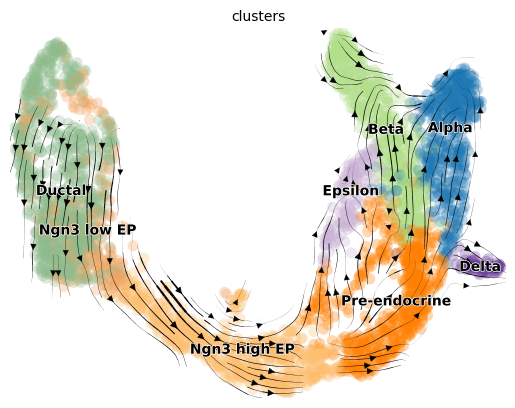

In [4]:
sc.pp.neighbors(adata)
scv.tl.velocity_graph(adata)
scv.pl.velocity_embedding_stream(adata, color='clusters')

computing velocity graph (using 1/64 cores)
    finished (0:00:01) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


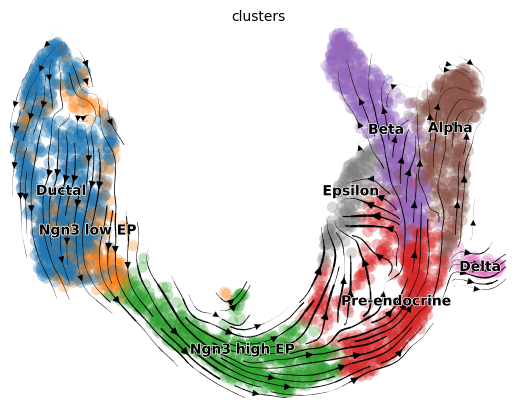

In [5]:
adata_gp = sc.AnnData(X=adata.obsm['z'])

adata_gp.obs = adata.obs.copy()
adata_gp.var_names = adata.uns['terms']
adata_gp.layers['velocity'] = adata.obsm['velocity_gp']
adata_gp.layers['spliced'] = adata.obsm['z']
adata_gp.obsm['X_umap'] = adata.obsm['X_umap']

sc.pp.neighbors(adata_gp)
scv.tl.velocity_graph(adata_gp)
scv.pl.velocity_embedding_stream(adata_gp, color='clusters')

computing velocity graph (using 1/64 cores)
    finished (0:00:02) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


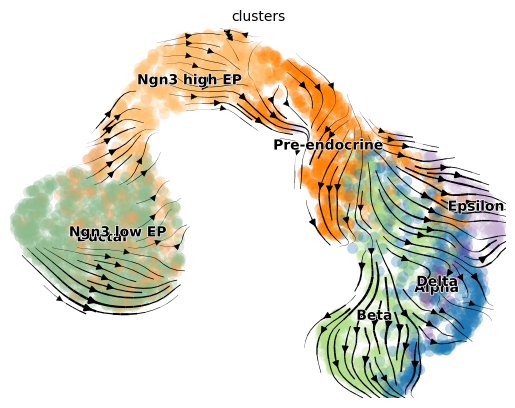

In [6]:
sc.pp.neighbors(adata, use_rep='z')
sc.tl.umap(adata)
scv.tl.velocity_graph(adata)
scv.pl.velocity_embedding_stream(adata, color='clusters')

computing velocity graph (using 1/64 cores)
    finished (0:00:01) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


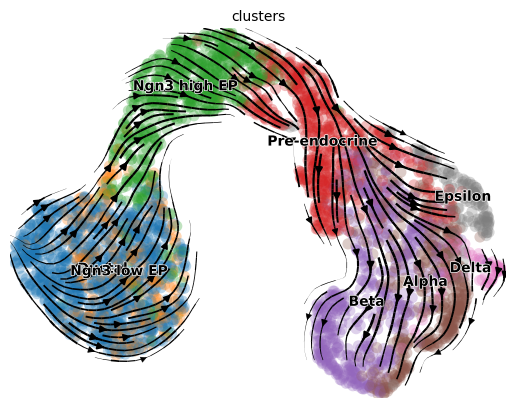

In [7]:
sc.pp.neighbors(adata_gp)
sc.tl.umap(adata_gp)
scv.tl.velocity_graph(adata_gp)
scv.pl.velocity_embedding_stream(adata_gp, color='clusters')

In [8]:
adata

AnnData object with n_obs × n_vars = 3696 × 1805
    obs: 'clusters_coarse', 'clusters', 'S_score', 'G2M_score', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts', 'velocity_self_transition'
    var: 'highly_variable_genes', 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'highly_variable'
    uns: 'clusters_coarse_colors', 'clusters_colors', 'day_colors', 'indices', 'log1p', 'neighbors', 'pca', 'terms', 'velocity_graph', 'velocity_graph_neg', 'velocity_params', 'umap'
    obsm: 'X_pca', 'X_umap', 'velocity_gp', 'z', 'velocity_umap'
    varm: 'I', 'PCs'
    layers: 'Ms', 'Mu', 'recon', 'recon_u', 'spliced', 'unspliced', 'velocity', 'velocity_u'
    obsp: 'connectivities', 'distances'

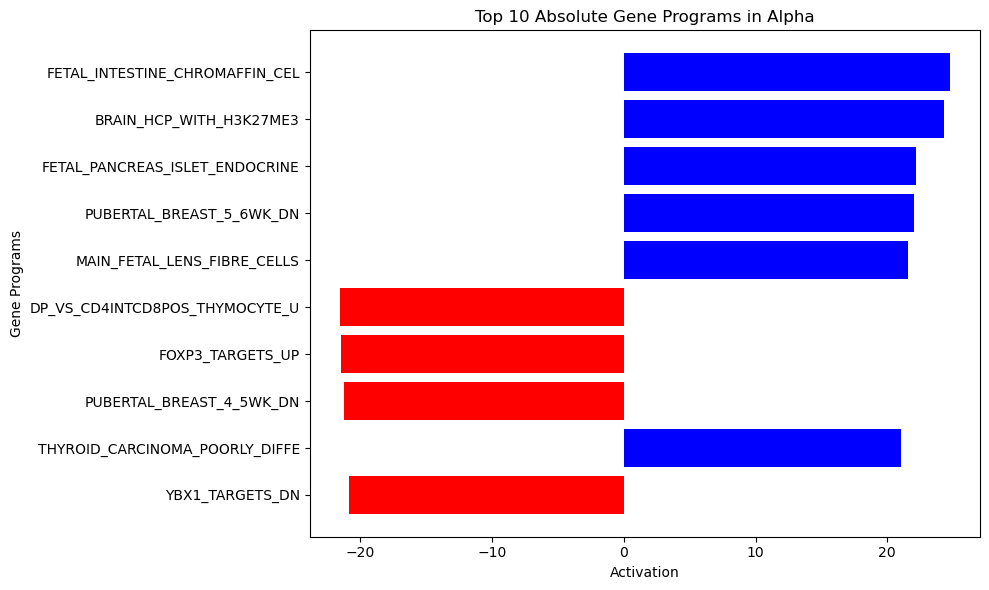

In [9]:
plot_top_gps_per_celltype(adata,
                        groupby="clusters", 
                        latent_key="z",
                        term_key="terms",
                        n=10,
                        target_group='Alpha')

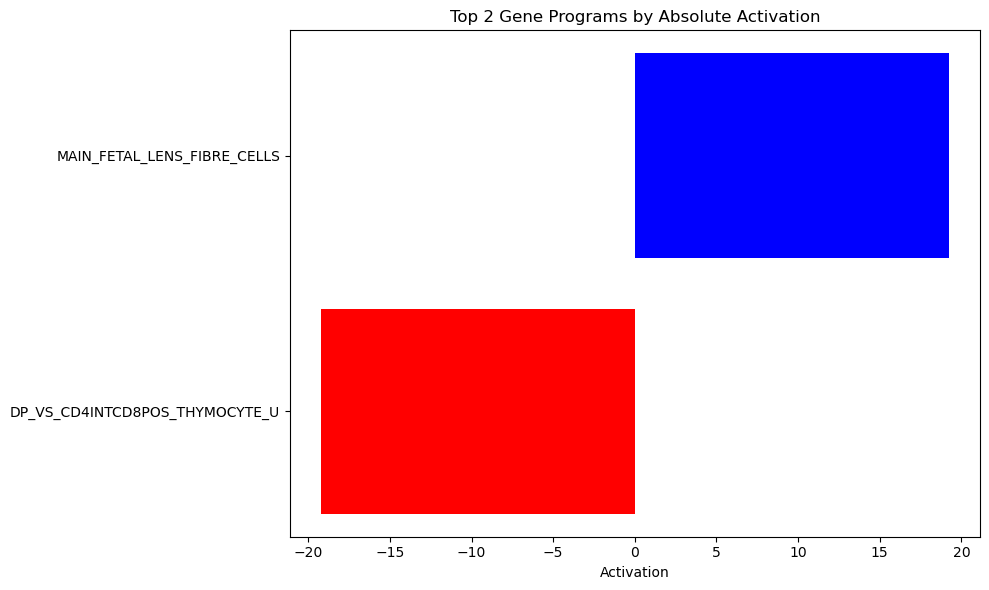

In [10]:
plot_top_gps_activation(adata, latent_key="z", terms_key="terms", n=2)

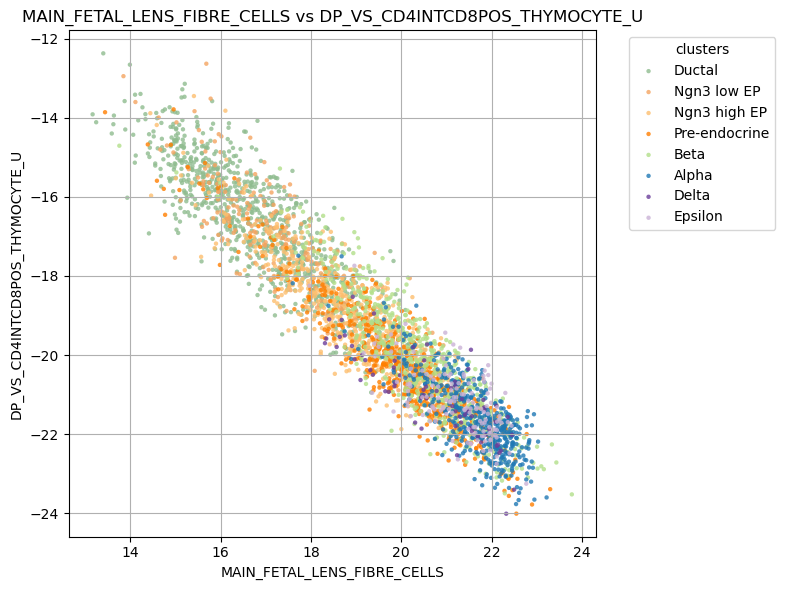

In [11]:
term_x = 'MAIN_FETAL_LENS_FIBRE_CELLS'
term_y = 'DP_VS_CD4INTCD8POS_THYMOCYTE_U'
scatter_terms(adata,
                term_x, 
                term_y, 
                latent_key="z", 
                term_key="terms", 
                groupby="clusters",
                s=10,
                alpha=0.8)

In [12]:
model = lineageVI(
    adata,
    n_hidden=128,
    mask_key='I',
    gene_prior=True,
    seed=0
)

model.eval()

lineageVI(
  (encoder): Encoder(
    (encoder): Sequential(
      (0): Linear(in_features=3610, out_features=128, bias=True)
      (1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (2): ReLU()
    )
    (mean_layer): Linear(in_features=128, out_features=647, bias=True)
    (logvar_layer): Linear(in_features=128, out_features=647, bias=True)
  )
  (gene_decoder): MaskedLinearDecoder(
    (linear): Linear(in_features=647, out_features=3610, bias=True)
  )
  (velocity_decoder): VelocityDecoder(
    (shared_decoder): Sequential(
      (0): Linear(in_features=647, out_features=128, bias=True)
      (1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (2): ReLU()
    )
    (gp_velocity_decoder): Sequential(
      (0): Linear(in_features=128, out_features=647, bias=True)
    )
    (gene_velocity_decoder): Sequential(
      (0): Linear(in_features=128, out_features=5415, bias=True)
      (1): Softplus(beta=1.0, threshold=20.0)
    )
  )
)

In [13]:
adata.X.data

array([0.8110648, 0.8110648, 2.8480403, ..., 0.7158527, 0.7158527,
       1.1287732], shape=(1579734,), dtype=float32)

In [14]:
unspliced = torch.tensor(adata.layers['unspliced'].toarray())
spliced = torch.tensor(adata.layers['spliced'].toarray())
x = torch.concatenate([unspliced, spliced], dim=1)
x.shape

torch.Size([3696, 3610])

In [15]:
z, mean, logvar = model.encoder(x)

In [16]:
def forward_encoder(model, x):
    z, mean, logvar = model.encoder(x)
    return z, mean, logvar

z, mean, logvar = forward_encoder(model, x)

'''def sample_z(model, x, n_samples):
    _, mean, logvar = forward_encoder(x)
    for sample in range(n_samples):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mean + eps * std'''

def forward_gene_decoder(model, z):
    x_rec = model.gene_decoder(z)
    return x_rec

x_rec = forward_gene_decoder(model, z)

def forward_velocity_decoder(model, z, x):
    velocity, velocity_u = model.velocity_decoder(z, x)
    return velocity, velocity_u

velocity, velocity_u = forward_velocity_decoder(model, z, x)

In [17]:
mean

tensor([[-0.3101,  0.2200,  0.2873,  ..., -0.0503,  0.3417, -1.0637],
        [-0.5487,  0.1596,  0.9625,  ...,  0.2991,  0.1728, -0.4267],
        [-0.8913,  0.4050,  0.8815,  ...,  0.1913,  0.6796, -0.9974],
        ...,
        [-0.5315, -0.1154,  0.6950,  ...,  0.4388,  0.2156, -0.4392],
        [-0.7427, -0.1048,  1.0206,  ..., -0.1674, -0.0335, -0.9170],
        [-0.4026,  0.1414,  0.8096,  ...,  0.1749,  0.6379, -0.7231]],
       grad_fn=<AddmmBackward0>)

In [19]:
def latent_enrich(
        adata,
        model,
        groups,
        comparison='rest',
        n_sample=5000,
        use_directions=False,
        directions_key='directions',
        select_terms=None,
        exact=True,
        key_added='bf_scores'
    ):
        """Gene set enrichment test for the latent space. Test the hypothesis that latent scores
           for each term in one group (z_1) is bigger than in the other group (z_2).

           Puts results to `adata.uns[key_added]`. Results are a dictionary with
           `p_h0` - probability that z_1 > z_2, `p_h1 = 1-p_h0` and `bf` - bayes factors equal to `log(p_h0/p_h1)`.

           Parameters
           ----------
           groups: String or Dict
                A string with the key in `adata.obs` to look for categories or a dictionary
                with categories as keys and lists of cell names as values.
           comparison: String
                The category name to compare against. If 'rest', then compares each category against all others.
           n_sample: Integer
                Number of random samples to draw for each category.
           use_directions: Boolean
                If 'True', multiplies the latent scores by directions in `adata`.
           directions_key: String
                The key in `adata.uns` for directions.
           select_terms: Array
                If not 'None', then an index of terms to select for the test. Only does the test
                for these terms.
           adata: AnnData
                An AnnData object to use. If 'None', uses `self.adata`.
           exact: Boolean
                Use exact probabilities for comparisons.
           key_added: String
                key of adata.uns where to put the results of the test.
        """

        if isinstance(groups, str):
            cats_col = adata.obs[groups]
            cats = cats_col.unique()
        elif isinstance(groups, dict):
            cats = []
            all_cells = []
            for group, cells in groups.items():
                cats.append(group)
                all_cells += cells
            adata = adata[all_cells]
            cats_col = pd.Series(index=adata.obs_names, dtype=str)
            for group, cells in groups.items():
                cats_col[cells] = group
        else:
            raise ValueError("groups should be a string or a dict.")

        if comparison != "rest" and isinstance(comparison, str):
            comparison = [comparison]

        if comparison != "rest" and not set(comparison).issubset(cats):
            raise ValueError("comparison should be 'rest' or among the passed groups")

        scores = {}

        for cat in cats:
            if cat in comparison:
                continue

            cat_mask = cats_col == cat
            if comparison == "rest":
                others_mask = ~cat_mask
            else:
                others_mask = cats_col.isin(comparison)

            choice_1 = np.random.choice(cat_mask.sum(), n_sample)
            choice_2 = np.random.choice(others_mask.sum(), n_sample)

            adata_cat = adata[cat_mask][choice_1]
            adata_others = adata[others_mask][choice_2]

            if use_directions:
                directions = adata.uns[directions_key]
            else:
                directions = None

            z0, means0, vars0 = forward_encoder(model, adata_cat.X)
            z1, means1, vars1 = forward_encoder(model, adata_others.X)

            if not exact:
                if directions is not None:
                    z0 *= directions
                    z1 *= directions

                if select_terms is not None:
                    z0 = z0[:, select_terms]
                    z1 = z1[:, select_terms]

                to_reduce = z0 > z1

                zeros_mask = (np.abs(z0).sum(0) == 0) | (np.abs(z1).sum(0) == 0)
            else:
                from scipy.special import erfc

                means0, vars0 = z0
                means1, vars1 = z1

                if directions is not None:
                    means0 *= directions
                    means1 *= directions

                if select_terms is not None:
                    means0 = means0[:, select_terms]
                    means1 = means1[:, select_terms]
                    vars0 = vars0[:, select_terms]
                    vars1 = vars1[:, select_terms]

                to_reduce = (means1 - means0) / np.sqrt(2 * (vars0 + vars1))
                to_reduce = 0.5 * erfc(to_reduce)

                zeros_mask = (np.abs(means0).sum(0) == 0) | (np.abs(means1).sum(0) == 0)

            p_h0 = np.mean(to_reduce, axis=0)
            p_h1 = 1.0 - p_h0
            epsilon = 1e-12
            bf = np.log(p_h0 + epsilon) - np.log(p_h1 + epsilon)

            p_h0[zeros_mask] = 0
            p_h1[zeros_mask] = 0
            bf[zeros_mask] = 0

            scores[cat] = dict(p_h0=p_h0, p_h1=p_h1, bf=bf)

        adata.uns[key_added] = scores

In [21]:
adata

AnnData object with n_obs × n_vars = 3696 × 1805
    obs: 'clusters_coarse', 'clusters', 'S_score', 'G2M_score', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts', 'velocity_self_transition'
    var: 'highly_variable_genes', 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'highly_variable'
    uns: 'clusters_coarse_colors', 'clusters_colors', 'day_colors', 'indices', 'log1p', 'neighbors', 'pca', 'terms', 'velocity_graph', 'velocity_graph_neg', 'velocity_params', 'umap'
    obsm: 'X_pca', 'X_umap', 'velocity_gp', 'z', 'velocity_umap'
    varm: 'I', 'PCs'
    layers: 'Ms', 'Mu', 'recon', 'recon_u', 'spliced', 'unspliced', 'velocity', 'velocity_u'
    obsp: 'connectivities', 'distances'

In [20]:
latent_enrich(
        adata,
        model,
        groups='clusters',
        comparison='rest',
        n_sample=5000,
        use_directions=False,
        directions_key='directions',
        select_terms=None,
        exact=True,
        key_added='bf_scores'
    )

TypeError: linear(): argument 'input' (position 1) must be Tensor, not SparseCSRMatrixView

In [ ]:
plot_abs_bfs(adata, scores_key="bf_scores", terms="terms",
                keys=None, n_cols=3)

KeyError: 'bf_scores'